In [1]:
import statsbomb as sb
from tqdm import tqdm
import re
import random
import numpy as np
from math import sqrt
from collections import defaultdict, Counter
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib import collections as mc

from scipy.spatial import distance
from math import pi

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import pickle

/usr/local/lib/python3.7/site-packages/statsbomb/utils.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  columns = yaml.load(open(os.path.join(os.path.dirname(__file__), 'events.yaml')))


In [2]:
import sys
sys.path.append('../')
from model import *
from preproc import *
from config import *
from embedding import *

In [3]:
res = wc_events(events, teams)
data, players, _ = generate_dataset(res, data_col, play_patterns,
                                    height_patterns, players_col, types_col,
                                    X=X, Y=Y)
players_list, player2idx, idx2player = create_players_data(players,
                                                           100)
data, players = filter_data(players, data, players_list)

100%|██████████| 64/64 [01:36<00:00,  1.55s/it]


In [4]:
model = torch.load('../Data/Player2Vec.pth')

with open('../Data/player_emb.pickle', 'rb') as f:
    emb = pickle.load(f)
    
with open('../Data/team_emb.pickle', 'rb') as f:
    team_emb = pickle.load(f)

/usr/local/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [5]:
players_list[random.randint(0, len(players_list)-1)]

'Andreas Christensen'

In [6]:
emb.most_common('Sergei Ignashevich')

[('Sergei Ignashevich', 1.0),
 ('Ramin Rezaeian', 0.9915658235549927),
 ('Robin Olsen', 0.9724604487419128),
 ('Jordan Pickford', 0.9682353138923645),
 ('Kléper Laveran Lima Ferreira', 0.9665459990501404),
 ('Kasper Schmeichel', 0.9647150039672852),
 ('Thibaut Courtois', 0.9636041522026062),
 ('Néstor Fernando Muslera Micol', 0.9527627229690552),
 ('Danijel Subašić', 0.9448751211166382),
 ('Hugo Lloris', 0.9338892698287964)]

In [7]:
emb.most_common('Aleksandr Golovin')

[('Aleksandr Golovin', 1.0),
 ('Yasir Gharsan Al Shahrani', 0.922083854675293),
 ('José Paulo Bezzera Maciel Júnior', 0.8460330963134766),
 ('Olivier Giroud', 0.8393037915229797),
 ('Yuto Nagatomo', 0.8262684941291809),
 ('Makoto Hasebe', 0.7864456176757812),
 ('Mario Mandžukić', 0.7718320488929749),
 ('Ivan Perišić', 0.7321248650550842),
 ('Thomas Müller', 0.7067509889602661),
 ('Marouane Fellaini-Bakkioui', 0.6853911280632019)]

In [8]:
emb.most_common('Cristiano Ronaldo dos Santos Aveiro')

[('Cristiano Ronaldo dos Santos Aveiro', 1.0),
 ('Radamel Falcao García Zárate', 0.986106812953949),
 ('Erick Javier Davis Grajales', 0.9845582842826843),
 ('André Martín Carrillo Díaz', 0.9775140285491943),
 ('Gylfi Þór Sigurðsson', 0.9607445001602173),
 ('Sergej Milinković-Savić', 0.9544313549995422),
 ('Artem Dzyuba', 0.9390392899513245),
 ('Younès Belhanda', 0.930273175239563),
 ('Mbark Boussoufa', 0.9116463661193848),
 ('Thomas Müller', 0.8980507850646973)]

In [9]:
emb.most_common('Thibaut Courtois')

[('Thibaut Courtois', 1.0),
 ('Néstor Fernando Muslera Micol', 0.9749547243118286),
 ('Sergei Ignashevich', 0.9636041522026062),
 ('Kléper Laveran Lima Ferreira', 0.9580315351486206),
 ('Jordan Pickford', 0.9576630592346191),
 ('William Troost-Ekong', 0.9550248980522156),
 ('Ramin Rezaeian', 0.942228376865387),
 ('Yann Sommer', 0.9353172183036804),
 ('Robin Olsen', 0.9311882853507996),
 ('Davinson Sánchez Mina', 0.9210401177406311)]

In [10]:
def plot_radar(players_names, embed, yticks=[0.02, 0.04, 0.08], ytsize=7, ylim=0.1, subplot=111):
    players_dict = {}
    for name in players_names:
        players_dict[name] = [x if x > 0 else 0.0 for x in list(embed[name])]
        
    players = list(players_dict.keys())
    df = pd.DataFrame({
    'player': players
    })
    for i in range(len(list(players_dict.values())[0])):
        df[str(i)] = [players_dict[key][i] for key in players]
    
    categories=list(df)[1:]
    N = len(categories)
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    ax = plt.subplot(subplot, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories)
    
    ax.set_rlabel_position(0)
    plt.yticks(yticks, [str(x) for x in yticks], color="grey", size=ytsize)
    plt.ylim(0, ylim)
    
    for i in range(df.index.size):
        values=df.loc[i].drop(df.columns[0]).values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=df[df.columns[0]].tolist()[i])
        ax.fill(angles, values, 'b', alpha=0.1)
        
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

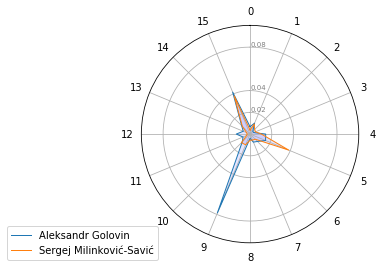

In [11]:
# plot_radar(df)
plot_radar(['Aleksandr Golovin', 'Sergej Milinković-Savić'], emb, [0.02, 0.04, 0.08], 7, 0.1)

In [12]:
player = 'Gerard Piqué Bernabéu'
mc = emb.most_common(player, 5)
names = [name for name, val in mc]
mc

[('Gerard Piqué Bernabéu', 1.0),
 ('Nicolás Hernán Otamendi', 0.992576539516449),
 ('Thiago Emiliano da Silva', 0.9694604873657227),
 ('Sergio Ramos García', 0.9536228179931641),
 ('William Silva de Carvalho', 0.8295530080795288)]

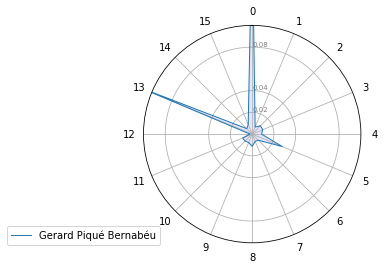

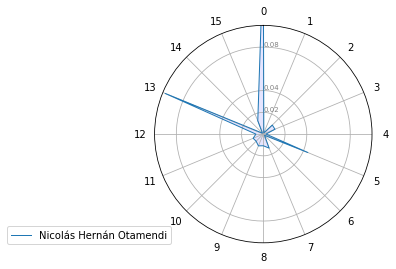

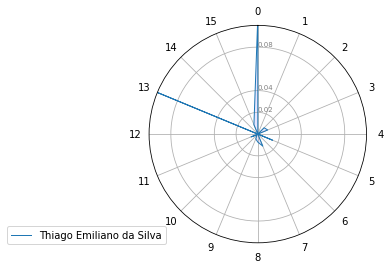

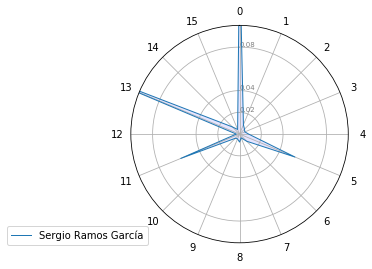

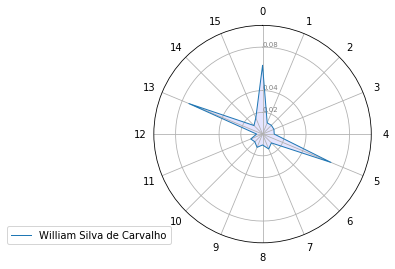

In [13]:
for name in names:
    plot_radar([name], emb)

In [14]:
positions, pos_list, pos2id = create_positions(res)

100%|██████████| 64/64 [00:59<00:00,  1.16it/s]


In [15]:
pos2id_classes = create_positions_id()

In [16]:
positions_id = make_positions_id(positions, pos2id_classes)

In [17]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)

vectors = [emb[name] for name in players_list]

tsne_results = tsne.fit_transform(vectors)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 250 samples in 0.005s...
[t-SNE] Computed neighbors for 250 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 250 / 250
[t-SNE] Mean sigma: 0.037863
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.414261
[t-SNE] KL divergence after 950 iterations: 0.415370


In [18]:
pca = PCA(n_components=2)

vectors = [emb[name] for name in players_list]

pca_results = pca.fit_transform(vectors)

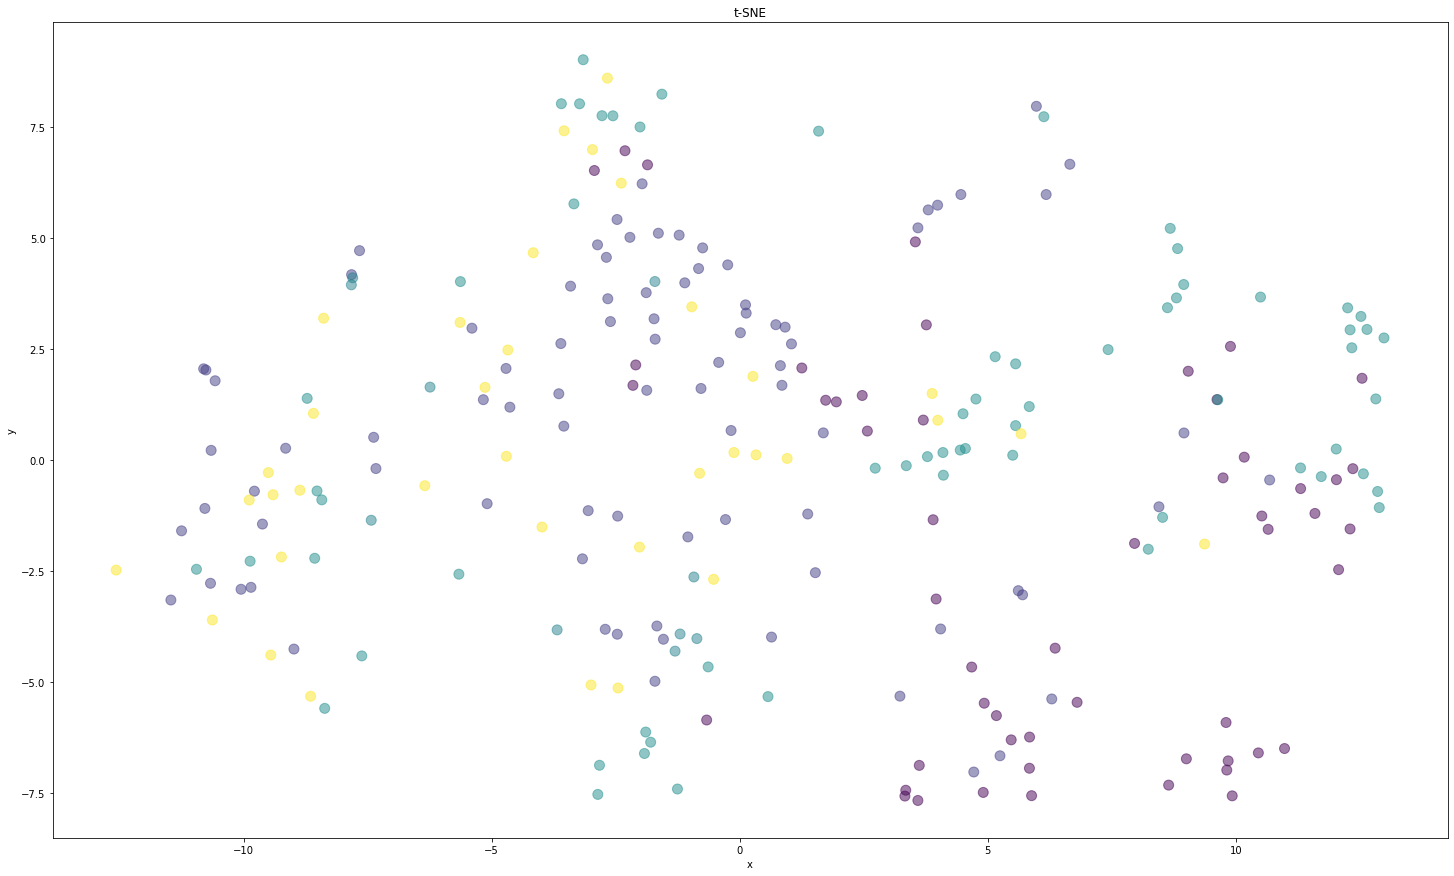

In [19]:
theta = 2 * np.pi * np.random.rand(len(list(pos_classes.keys())))
np.random.shuffle(theta)
colors = [theta[x] for x in [positions_id[name] for name in players_list]] 

fig, ax = plt.subplots(figsize=(25, 15))
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5, c=colors, s=[100]*len(tsne_results))
plt.title('t-SNE')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

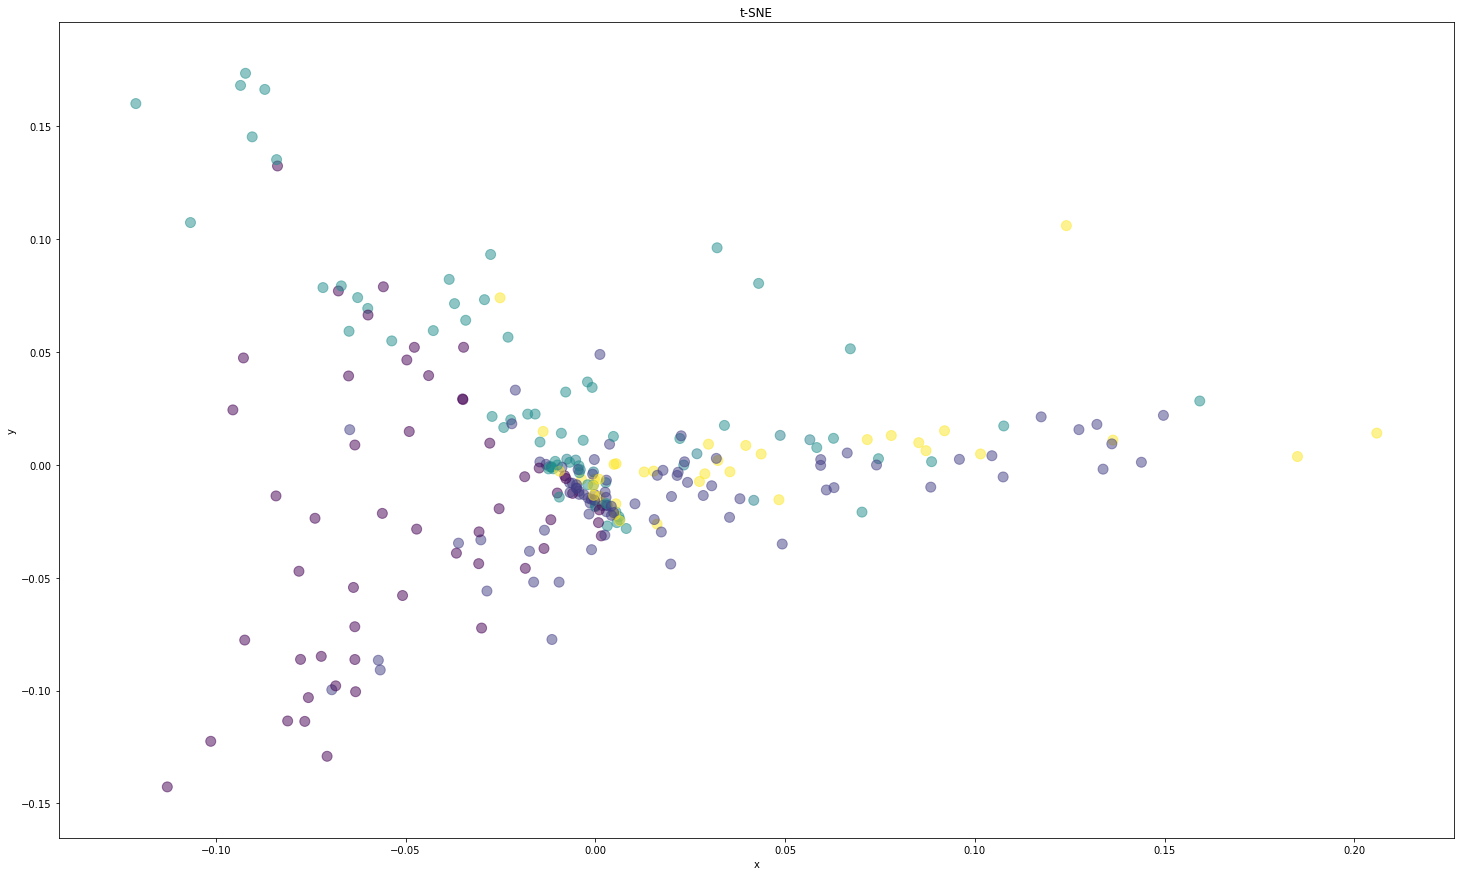

In [20]:
fig, ax = plt.subplots(figsize=(25, 15))
ax.scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.5, c=colors, s=[100]*len(pca_results))
plt.title('t-SNE')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

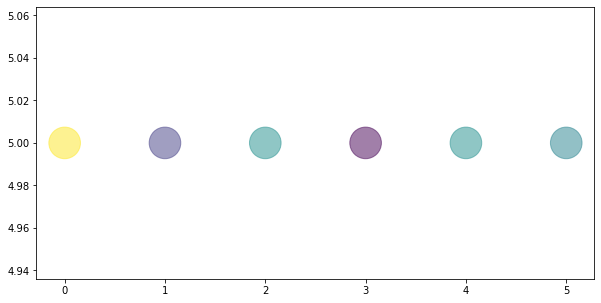

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(list(pos_classes.keys()), [5 for i in range(len(list(pos_classes.keys())))], 
           alpha=0.5, c=theta, s=[1000] * len(theta))
plt.show()
print()

In [22]:
teams, teams_vec = create_teams(res, players_list, emb)

100%|██████████| 64/64 [01:04<00:00,  1.14it/s]


In [23]:
teams_list = list(teams_vec.keys())

In [24]:
team_emb.most_common('Spain', 5)

[('Spain', 1.0),
 ('Brazil', 0.8938555717468262),
 ('Germany', 0.8632105588912964),
 ('Belgium', 0.8203027844429016),
 ('Saudi Arabia', 0.8156481385231018)]

In [25]:
team_emb.most_common('Russia', 5)

[('Russia', 1.0),
 ('Sweden', 0.9642917513847351),
 ('Colombia', 0.8837975263595581),
 ('Iran', 0.8816269636154175),
 ('Denmark', 0.8613367676734924)]

In [26]:
vectors = [team_emb[name] for name in teams_list]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(vectors)

pca = PCA(n_components=2)
pca_results = pca.fit_transform(vectors)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 32 samples in 0.000s...
[t-SNE] Computed neighbors for 32 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 32 / 32
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.925533
[t-SNE] KL divergence after 1000 iterations: 0.521484


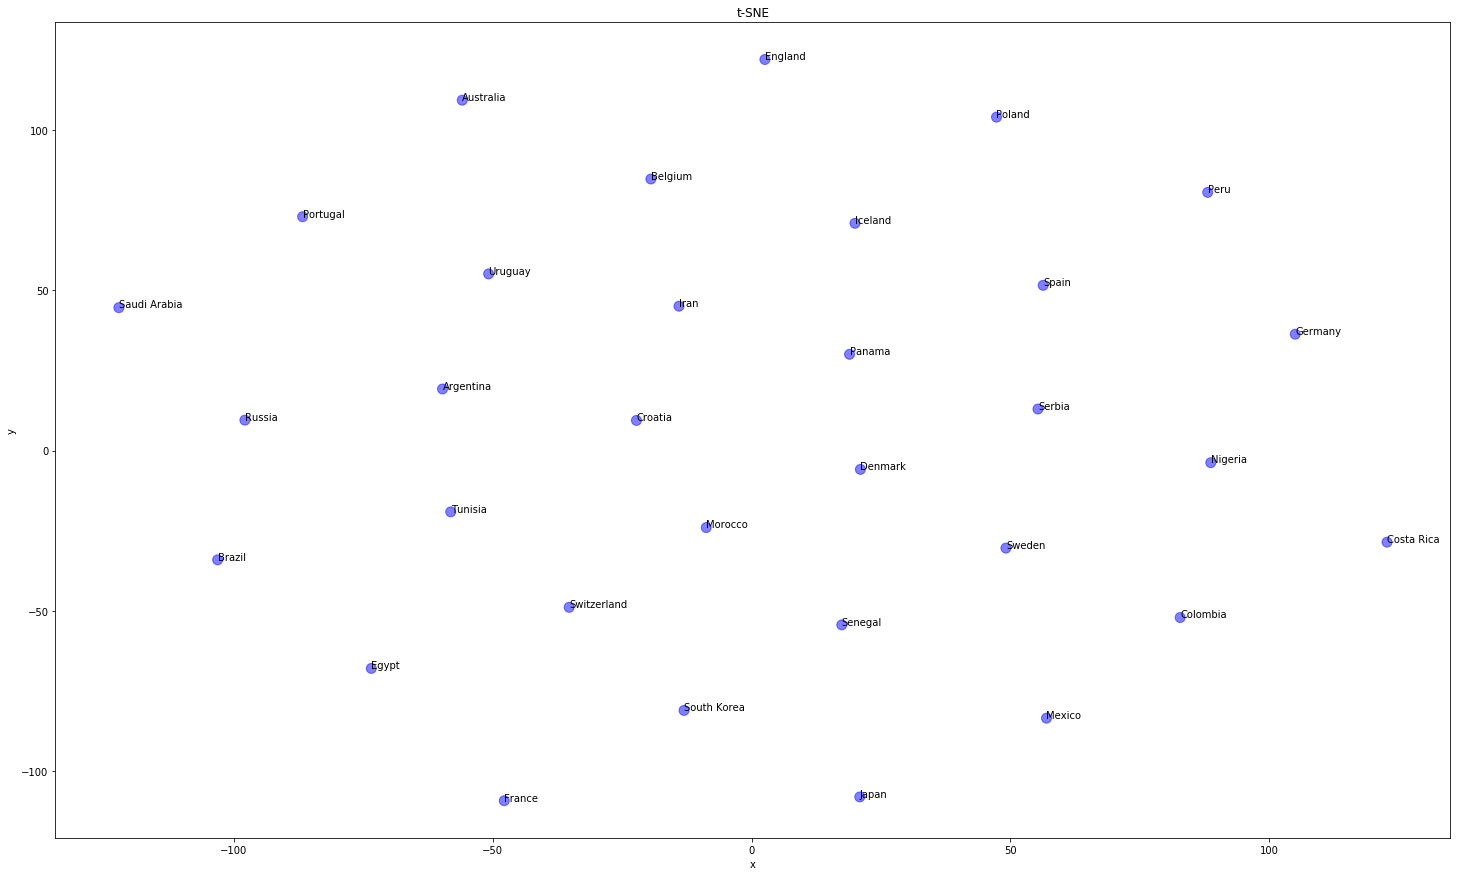

In [27]:
colors = ['b'] * len(vectors) 

fig, ax = plt.subplots(figsize=(25, 15))
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5, c=colors, s=[100]*len(tsne_results))
plt.title('t-SNE')
plt.xlabel('x')
plt.ylabel('y')

for i, team in enumerate(teams_list):
    ax.annotate(team, (tsne_results[i][0], tsne_results[i][1]))

plt.show()

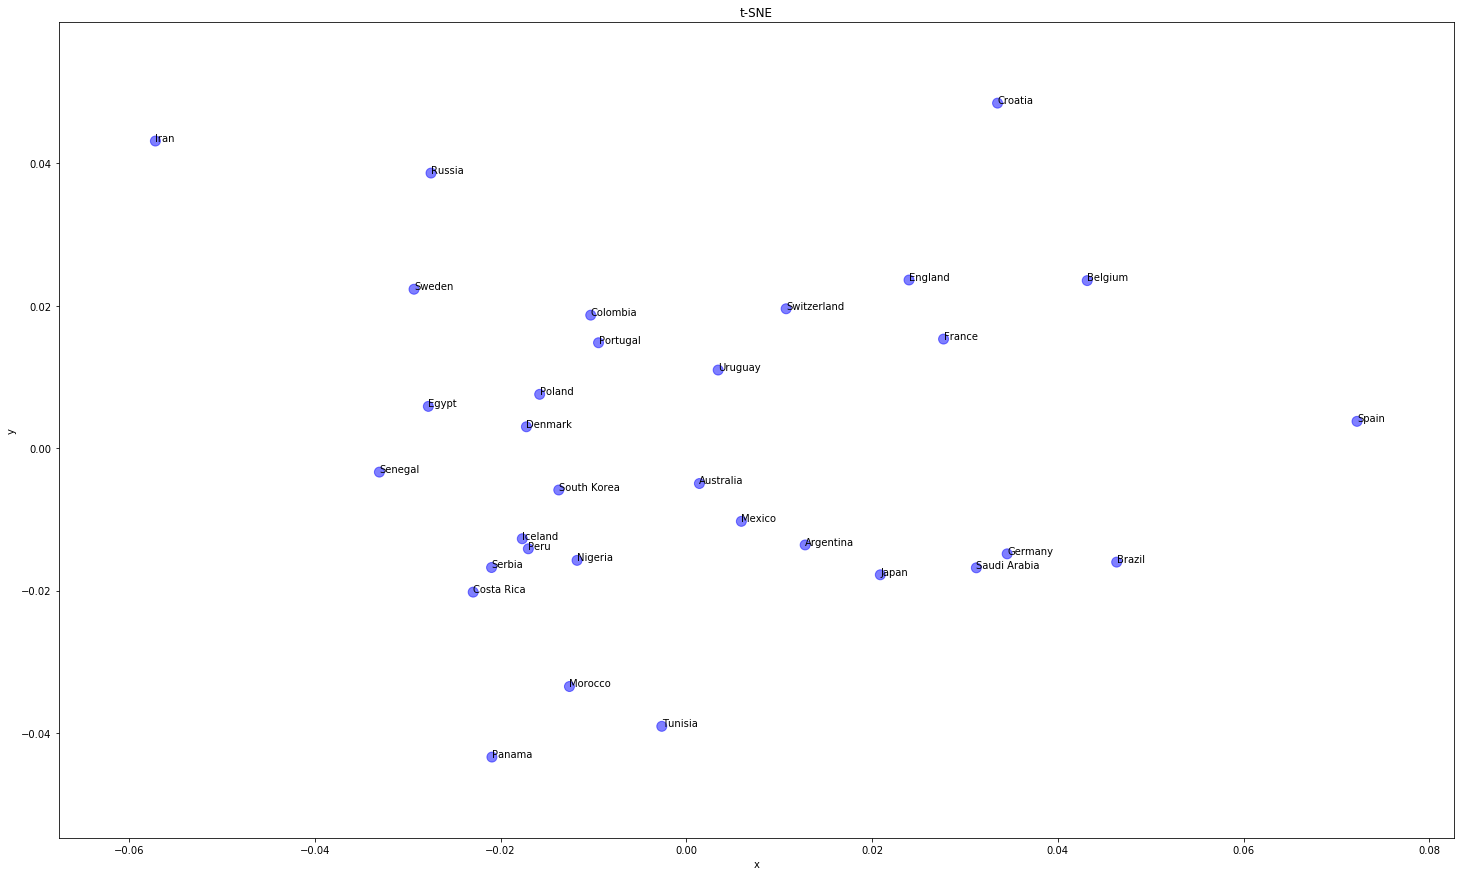

In [28]:
fig, ax = plt.subplots(figsize=(25, 15))
ax.scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.5, c=colors, s=[100]*len(pca_results))
plt.title('t-SNE')
plt.xlabel('x')
plt.ylabel('y')

for i, team in enumerate(teams_list):
    ax.annotate(team, (pca_results[i][0], pca_results[i][1]))

plt.show()

In [29]:
posCB_id = {key: val for key, val in positions_id.items() if val == 3 and key in players_list}

In [30]:
cb_players = list(posCB_id.keys())
vectors = [emb[name] for name in cb_players]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(vectors)

pca = PCA(n_components=2)
pca_results = pca.fit_transform(vectors)

[t-SNE] Computing 52 nearest neighbors...
[t-SNE] Indexed 53 samples in 0.000s...
[t-SNE] Computed neighbors for 53 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 53 / 53
[t-SNE] Mean sigma: 0.126734
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.392464
[t-SNE] KL divergence after 1000 iterations: 0.448958


In [31]:
key_name = 'Sergio Ramos García'
key_ind = cb_players.index(key_name)

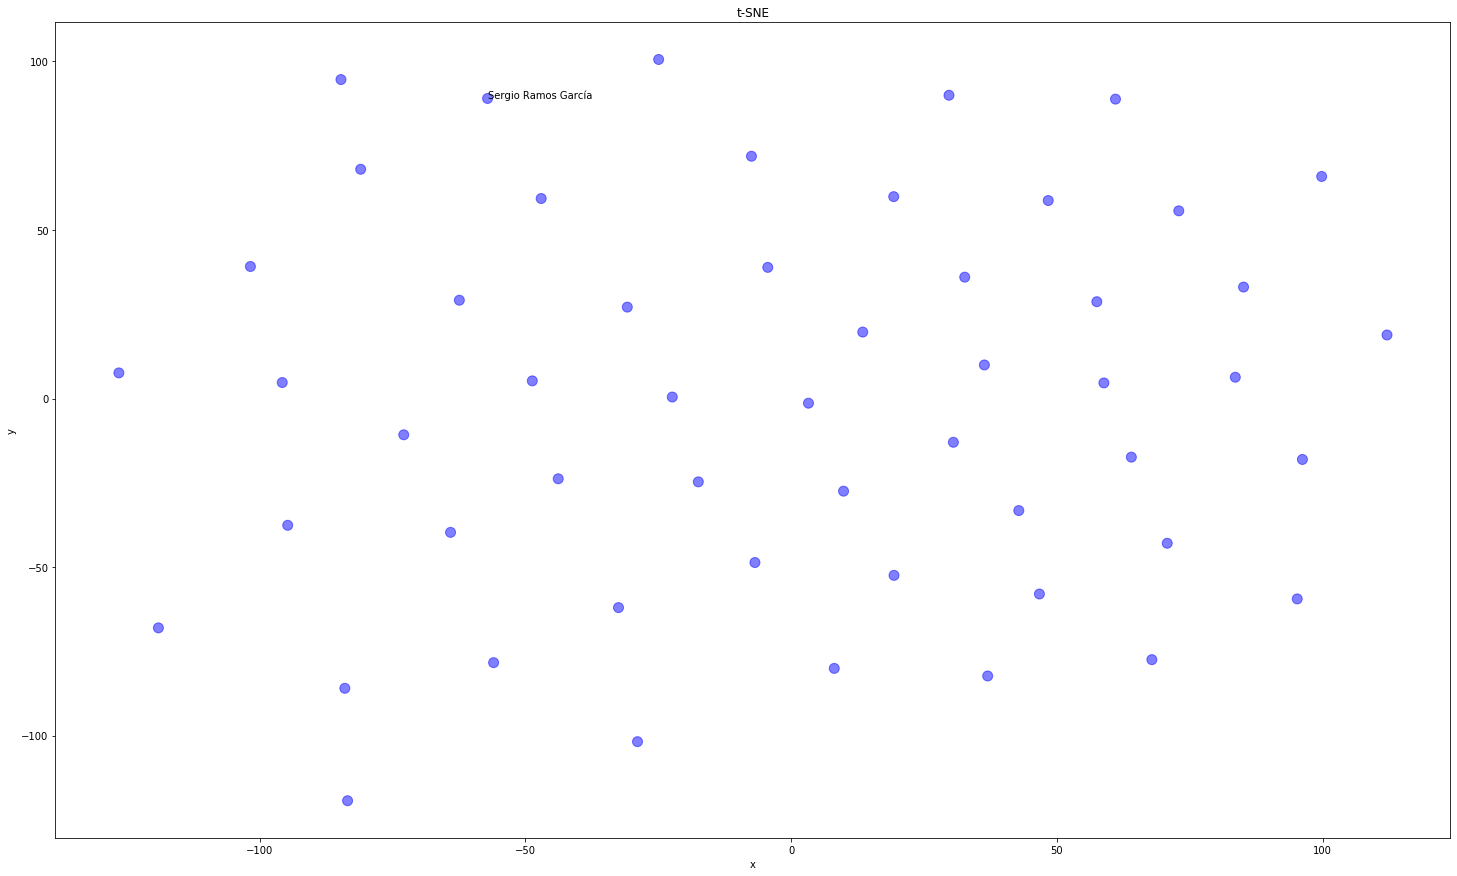

In [32]:
colors = ['b'] * len(vectors) 

fig, ax = plt.subplots(figsize=(25, 15))
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5, c=colors, s=[100]*len(tsne_results))
plt.title('t-SNE')
plt.xlabel('x')
plt.ylabel('y')

ax.annotate(key_name, (tsne_results[key_ind][0], tsne_results[key_ind][1]))

plt.show()

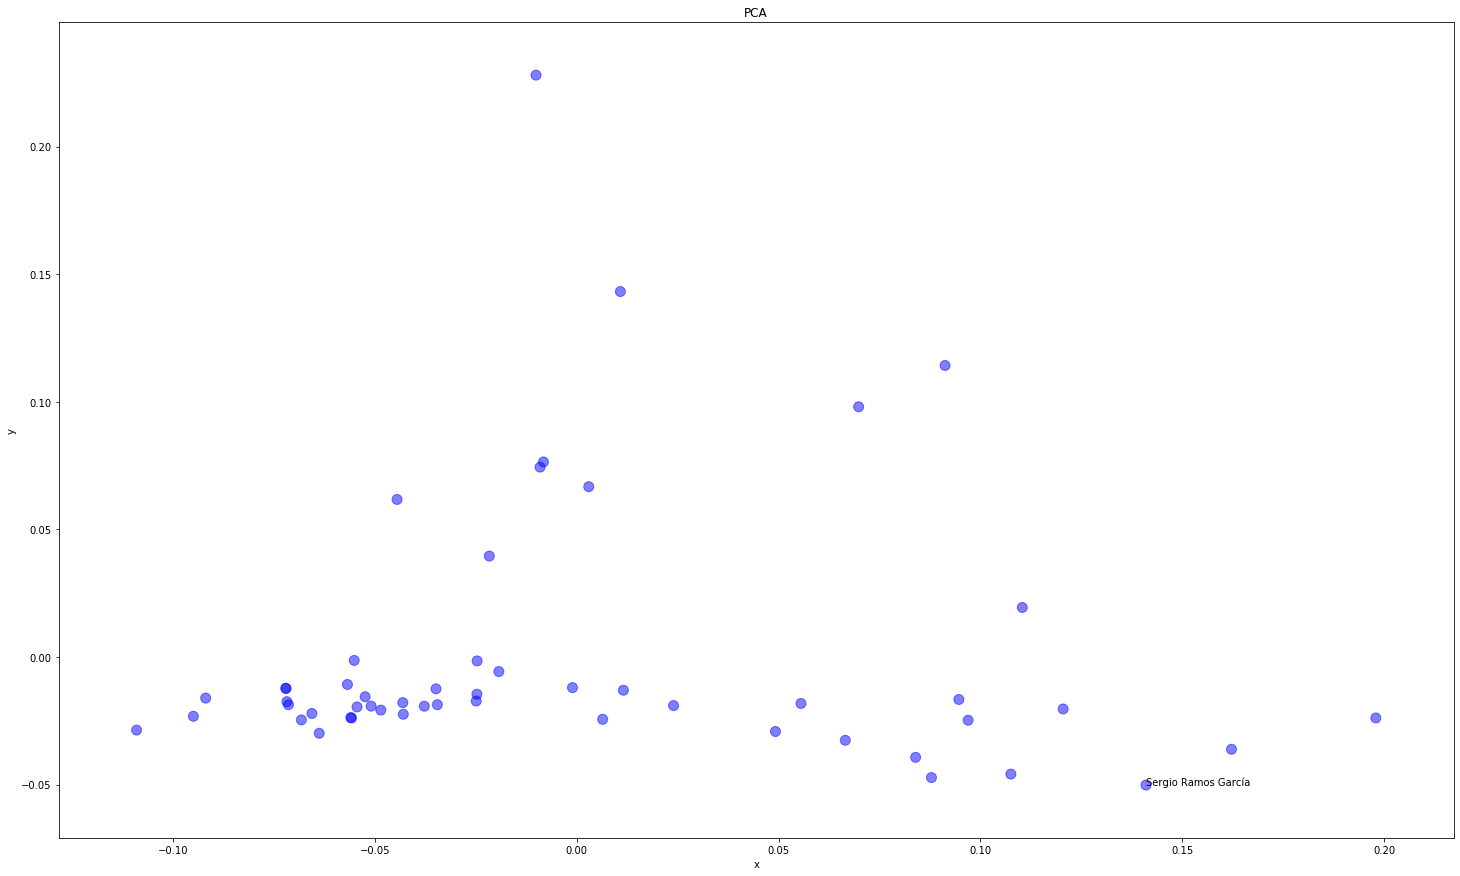

In [33]:
fig, ax = plt.subplots(figsize=(25, 15))
ax.scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.5, c=colors, s=[100]*len(pca_results))
plt.title('PCA')
plt.xlabel('x')
plt.ylabel('y')

ax.annotate(key_name, (pca_results[key_ind][0], pca_results[key_ind][1]))

plt.show()

In [34]:
player = key_name
mc = emb.most_common(player, 5)
names = [name for name, val in mc]
mc

[('Sergio Ramos García', 1.0),
 ('Thiago Emiliano da Silva', 0.9622002840042114),
 ('Nicolás Hernán Otamendi', 0.9580074548721313),
 ('Gerard Piqué Bernabéu', 0.9536228179931641),
 ('Dejan Lovren', 0.8918173909187317)]

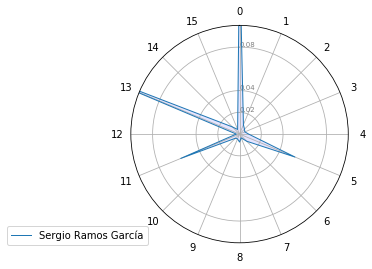

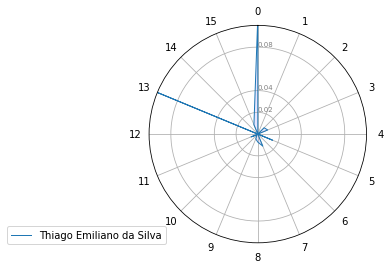

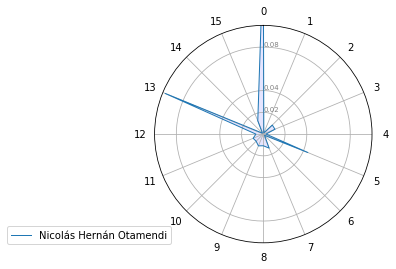

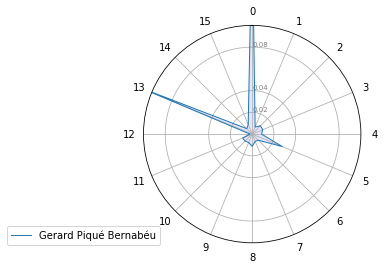

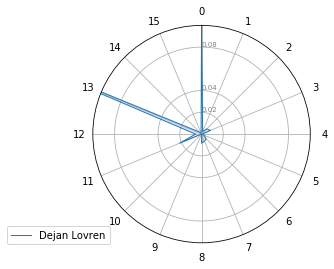

In [35]:
for name in names:
    plot_radar([name], emb)